In [1]:
# only on the first run
!rm -rf chroma_db

In [2]:
# install dependencies
!pip install langchain langchain-community llama-cpp-python tiktoken chromadb bertopic bert-score textstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 MB 7.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 8.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 

In [3]:
# import modules needed
import re
import umap
import torch
import random
import textwrap
import textstat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA, LatentDirichletAllocation

from bert_score import score
from bertopic import BERTopic
from langchain.chains import RetrievalQA
from langchain.vectorstores import Chroma
from langchain.prompts import PromptTemplate
from langchain.llms import HuggingFacePipeline
from langchain.docstore.document import Document
from sentence_transformers import SentenceTransformer
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModelForCausalLM, pipeline

In [4]:
file_path = '/content/df_cleaned.csv'

# read df
df = pd.read_csv(file_path)
df.head()

,title,authors,year_published,number,volume,journal,type,content,doi,file,abstract,cleaned_content,cleaned_abstract
0,Advanced Passive Operating System Fingerprinti...,"Hagos, Desta Haileselassie and Løland, Martin ...",2020,missing,missing,missing,inproceedings,Advanced Passive Operating System Fingerprinti...,10.1109/ICCCN49398.2020.9209694,doc28,"—Securing and managing large, complex enterpri...",Advanced Passive Operating System Fingerprinti...,"—Securing and managing large, complex enterpri..."
1,Artificial intelligence in the fertility clini...,"Riegler, M A and Stensen, M H and Witczak, O a...",2021,9.0,36,Human Reproduction,article,.................................................,10.1093/humrep/deab168,doc14,": In recent years, the amount of data produced...",.................................................,": In recent years, the amount of data produced..."
2,EvoDynamic: A Framework for the Evolution of G...,"Pontes-Filho, Sidney\nand Lind, Pedro\nand Yaz...",2020,missing,missing,missing,inproceedings,EvoDynamic: a framework for the evolution of\n...,missing,doc10,. Dynamical systems possess a computational ca...,EvoDynamic: a framework for the evolution of g...,. Dynamical systems possess a computational ca...
3,A general representation of dynamical systems ...,Sidney Pontes{-}Filho and\nAnis Yazidi and\nJi...,2019,missing,abs/1907.01856,CoRR,article,A general representation of dynamical systems ...,missing,doc11,—Dynamical systems are capable of performing c...,A general representation of dynamical systems ...,—Dynamical systems are capable of performing c...
4,Exploring Multilingual Word Embedding Alignmen...,"Aaby, Pernille\nand Biermann, Daniel\nand Yazi...",2023,missing,missing,missing,inproceedings,"\n \n \n \nAccepted manuscript \nAaby, P., Bi...",missing,doc12,". Contextual language models, such as transfor...","Accepted manuscript Aaby, P., Biermann, D., Ya...",". Contextual language models, such as transfor..."


In [5]:
#from huggingface_hub import login
#login()

In [6]:
def load_model(model_name="TinyLlama/TinyLlama-1.1B-Chat-v1.0"): # meta-llama/Llama-2-7b-chat-hf
    '''
    Loads a pre-trained model and its tokenizer from Hugging Face.

    Args:
        model_name (str, optional): model name to load.

    Returns:
        tuple: tuple containing the tokenizer and model.
    '''
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)
    return tokenizer, model

tokenizer, model = load_model()

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [7]:
# convert each row into a langchain document
documents = [
    Document(page_content=row["cleaned_content"], metadata={"title": row["title"], "authors": row["authors"], "file": row["file"], "year_published": row["year_published"], "abstract": row["abstract"]})
    for _, row in df.iterrows()
]

In [8]:
def split_documents(documents, chunk_size=500, chunk_overlap=50):
    '''
    Splits list of documents into smaller chunks for easier processing.

    Args:
        documents (list): list of documents to be split into chunks.
        chunk_size (int, optional): maximum size of each chunk in characters.
        chunk_overlap (int, optional): number of overlapping characters between consecutive chunks.

    Returns:
        tuple: containing chunks (list) of text chunks after splitting and chunk_counts (dict) for dictionary with count of chunks per document, using file name as key
    '''
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", " ", ""]
    )

    chunks = []
    chunk_counts = {}

    for doc in documents:
        doc_chunks = text_splitter.split_documents([doc])
        chunk_counts[doc.metadata["file"]] = len(doc_chunks)

        for chunk in doc_chunks:

            # include file name in chunk metadata
            chunk.metadata["file"] = doc.metadata["file"]
            chunks.append(chunk)

    print(f"Total chunks created: {len(chunks)} \n")
    return chunks, chunk_counts

chunked_documents, chunk_counts = split_documents(documents)

Total chunks created: 1969 



In [9]:
# display chunking info for a few documents
for doc in documents[:4]:
    num_chunks = chunk_counts.get(doc.metadata["file"], 0)
    print(f"File: {doc.metadata['file']}")
    print(f"Original document length: {len(doc.page_content)}")
    print(f"Number of chunks: {num_chunks}\n")

File: doc28
Original document length: 66818
Number of chunks: 149

File: doc14
Original document length: 68223
Number of chunks: 153

File: doc10
Original document length: 34247
Number of chunks: 77

File: doc11
Original document length: 22320
Number of chunks: 50



In [10]:
# load embedding model
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

<ipython-input-10-f4b9beb358bb>:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [11]:
# create Chroma vector database
vectorstore = Chroma.from_documents(documents=chunked_documents, embedding=embedding_model, persist_directory="chroma_db")

# save the database for future use
vectorstore.persist()

<ipython-input-11-e6ac6bd8d83b>:5: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectorstore.persist()


In [12]:
# load existing Chroma vector database
vectorstore = Chroma(persist_directory="chroma_db", embedding_function=embedding_model)

# define retriever
retriever = vectorstore.as_retriever()

<ipython-input-12-21ee20e820e9>:2: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(persist_directory="chroma_db", embedding_function=embedding_model)


In [13]:
# check the number of documents stored in ChromaDB
stored_count = vectorstore._collection.count()
expected_count = len(chunked_documents)

print(f"Stored documents in ChromaDB: {stored_count}")
print(f"Expected text splits: {expected_count}")

# validate indexing success
if stored_count == expected_count:
    print("All text splits are correctly stored in ChromaDB.")
else:
    print(f"Mismatch detected: {expected_count - stored_count} documents missing.")
    print("Some documents might not have been indexed properly.")


Stored documents in ChromaDB: 1969
Expected text splits: 1969
All text splits are correctly stored in ChromaDB.


In [14]:
# create an llm pipeline
llm_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=700,
    temperature=0.7,
    repetition_penalty=1.2,
)

# wrap pipeline for LangChain
llm = HuggingFacePipeline(pipeline=llm_pipeline)

Device set to use cuda:0
<ipython-input-14-d9eb674915d0>:12: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=llm_pipeline)


##Q/A Pipeline

In [15]:
# define a custom prompt
custom_prompt = PromptTemplate(
    template=(
        "Read the following research information and provide a concise answer to the question:\n\n"
        "{context}\n\n"
        "If the answer is not clear, acknowledge that you don't know, and do not make any assumptions. "
        "If there are multiple possible answers, focus on the most important points and summarize them in a paragraph.\n\n"
        "Question: {question}\n\n"
    ),
    input_variables=["context", "question"],
)

In [16]:
# initialize the QA Chain
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type="stuff", # uses full retrieved text as context, others are map redude, map rerank, refine
    chain_type_kwargs={"prompt": custom_prompt}
)

In [17]:
def generate_answer(query):
    '''
    Generates  answer to the user query using QA chain and retrieves relevant documents.

    Args:
        query (str): user query.

    Returns:
        str: generated answer.
    '''

    # generate answer using QA chain
    generated_answer = qa_chain.invoke(query)

    # if the answer is returned as a list, extract the first item
    if isinstance(generated_answer, list):
        generated_answer = generated_answer[0]

    # ensure the answer is a string
    if not isinstance(generated_answer, str):
        generated_answer = str(generated_answer)

    # retrieve relevant documents for query
    retrieved_docs = retriever.get_relevant_documents(query)

    # print relevant documents for context
    print("\n=== Relevant Information Retrieved ===\n")
    for i, doc in enumerate(retrieved_docs, 1):
        file_name = doc.metadata.get('file', 'Unknown')
        print(f"Chunk {i} (Title: {file_name}):\n{doc.page_content}\n")

    # return the generated answer and the retrieved documents
    return generated_answer, retrieved_docs

In [18]:
def calculate_sts(doc_text, generated_answer):
    '''
    Calculates the cosine similarity score between two texts using cosine similarity.

    Args:
        doc_text (str): a single document's content.
        generated_answer (str): answer generated by the model.

    Returns:
        float: cosine similarity.
    '''

    # get embeddings for both document text and generated answer
    doc_embedding = embedding_model.embed_documents([doc_text])
    answer_embedding = embedding_model.embed_documents([generated_answer])

    # compute cosine similarity
    sts_score = cosine_similarity(doc_embedding, answer_embedding)[0][0]
    return sts_score

In [19]:
def evaluate_answer(query):
    '''
    Evaluate answer by looking at Cosine Similarity between retrieved information and generated response.

    Args:
        query (str): user query.

    Prints:
        Generated answer, document titles, previews, and similarity scores.
    '''

    # generate the answer and retrieve relevant documents
    generated_answer, retrieved_docs = generate_answer(query)

    print(f"Generated Answer: {generated_answer}\n")

    # compare each retrieved document with the generated response
    for i, doc in enumerate(retrieved_docs, 1):
        doc_text = doc.page_content
        doc_title = doc.metadata.get('file', 'Unknown')

        # calculate similarity
        sts_score = calculate_sts(doc_text, generated_answer)

        # print the similarity result, including document title and chunk
        print(f"\n=== Similarity with Chunks {i} ===")
        print(f"Title: {doc_title}")
        print(f"Chunk: {doc_text[:300]}...")
        print(f"STS Score: {sts_score:.4f}")

user_query = "What is IRNN?"
evaluate_answer(user_query)


=== Relevant Information Retrieved ===

Chunk 1 (Title: doc18):
deep learning techniques will most likely replace the estab­ lished image analysis methods. This trend has been observed within other medical fields such as gastrointestinal diseases and radiology [23, A.M. Storås et al. The Ocular Surface 23 74–86 76 24]. A GAN is a combination of two neural networks: A generator and a discriminator competing against each other. The goal of the generator is to produce fake data similar to a set of real data. The discriminator re­ ceives both real data and the

Chunk 2 (Title: doc24):
reach this conclusion, an intensive analysis was performed by comparing ALMOST with the baseline solutions InceptionResNet [34] and DenseNet [35]). The detailed results with a full explana- tion are shown below. B. Quality of Outputs Table II shows the quality of results from ALMOST and the baseline solutions: InceptionResNet, DenseNet on Kvasir (V1), and Kvasir (V2). We varied the percentage of images used 

<ipython-input-17-d9d1a4af3eb4>:24: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(query)


In [20]:
def evaluate_answer(query1, query2):
    '''
    Evaluate answers by looking at Cosine Similarity between retrieved information and generated response
    for two similar questions.

    Args:
        query1 (str): first user query.
        query2 (str): second user query.

    Prints:
        Generated answers, document titles, previews, and similarity scores for both queries,
        and the similarity between the two generated answers.
    '''

    # generate answer and retrieve relevant documents for both queries
    generated_answer1, retrieved_docs1 = generate_answer(query1)
    generated_answer2, retrieved_docs2 = generate_answer(query2)

    print(f"Generated Answer for Query 1: {generated_answer1}\n")
    print(f"Generated Answer for Query 2: {generated_answer2}\n")

    # compare the answers and retrieved documents for each query
    for i, (doc1, doc2) in enumerate(zip(retrieved_docs1, retrieved_docs2), 1):
        doc_text1 = doc1.page_content
        doc_title1 = doc1.metadata.get('file', 'Unknown')
        doc_text2 = doc2.page_content
        doc_title2 = doc2.metadata.get('file', 'Unknown')

        # calculate similarity between document text and generated answers
        sts_score1 = calculate_sts(doc_text1, generated_answer1)
        sts_score2 = calculate_sts(doc_text2, generated_answer2)

        # print similarity results for each document
        print(f"\n=== Similarity with Chunks {i} ===")
        print(f"Query 1 - Title: {doc_title1}")
        print(f"Query 1 - Chunk: {doc_text1[:300]}...")
        print(f"Query 1 - STS Score: {sts_score1:.4f}")

        print(f"Query 2 - Title: {doc_title2}")
        print(f"Query 2 - Chunk: {doc_text2[:300]}...")
        print(f"Query 2 - STS Score: {sts_score2:.4f}")

    # calculate cosine similarity between generated answers
    answer_similarity = calculate_sts(generated_answer1, generated_answer2)

    # print similarity between generated answers
    print(f"\n=== Similarity Between Generated Answers ===")
    print(f"Cosine Similarity between Answers: {answer_similarity:.4f}")

user_query1 = "What is deep learning?"
user_query2 = "Could you explain what deep learning is?"
evaluate_answer(user_query1, user_query2)


=== Relevant Information Retrieved ===

Chunk 1 (Title: doc18):
Within AI, machine learning denotes a class of algorithms capable of learning from data rather than being programmed with explicit rules. AI, and particularly machine learning, is increasingly becoming an integral part of health care systems. The sub-field of machine learning known as deep learning uses deep artificial neural networks, and has gained increased attention in recent years, especially for its image and text recognition abilities. In the field of ophthalmology, deep learning has so

Chunk 2 (Title: doc18):
responsible for passing the data to the network, and one or more hidden layers. Networks with more than one hidden layer are called deep neural networks. The final layer is the output layer, providing the output of the entire network. Deep learning is a sub-field of machine learning involving training deep neural networks, which can be done both in a supervised and unsupervised manner. We encounter several d

##Summarization Pipeline

In [21]:
# initialize the QA chain
qa_chain2 = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type="stuff", # uses full retrieved text as context, others are map redude, map rerank, refine
)

In [22]:
# device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load models
sim_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
llm_model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0").to(device)
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

### Human Evaluation vs Automated Metrics

In [23]:
def evaluate_faithfulness(summary, abstract, model):
    """
    Measures faithfulness of generated summaries by comparing it to the original abstract
    using cosine similarity.
    """
    embeddings = model.encode([abstract, summary])
    similarity_score = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    return {"Cosine Similarity Score": similarity_score}

In [24]:
def evaluate_readability(summary):
    """
    Measures readability for non-experts using Flesch Reading Ease and Gunning Fog index.
    Flesch Reading Ease measures how easy the text is to read on a scale from 0-100,
    while Gunning Fog Index measures years of formal education needed to understand the text where 6
    is low and 17 is high.
    """
    flesch_score = textstat.flesch_reading_ease(summary)
    gunning_fog = textstat.gunning_fog(summary)
    return {
        "Flesch Reading Ease": flesch_score,
        "Gunning Fog Index": gunning_fog
    }

In [25]:
def abstract_summary_comparison(article_id, df, retriever, qa_chain2, sim_model):
    """
    Compares the original abstract with generated summaries.
    """
    # extract original abstract and title
    article = df.iloc[article_id]
    abstract = article["abstract"]
    title = article["title"]

    # retrieve relevant documents based on article title
    retrieved_docs = retriever.get_relevant_documents(title)
    if not retrieved_docs:
        return {
            "title": title,
            "original_abstract": abstract,
            "retrieved_docs": [],
            "generated_summaries": {level: "No relevant documents found." for level in ["basic", "intermediate", "specialized"]}
        }

    # define query levels
    queries = {
        "basic": f"Summarize the research article titled: '{title}'.",
        "intermediate": f"Summarize the research article '{title}' focusing on key findings and conclusions.",
        "specialized": f"Provide a detailed and specialized summary of the research article titled: '{title}', emphasizing the methodology, experimental design, and key findings. Ensure that the summary is focused on technical details and avoids any broad or generalized statements."
    }

    # generate summaries for each query level
    generated_summaries = {}
    for level, query in queries.items():
        response = qa_chain2.invoke(input={"query": query, "documents": retrieved_docs})
        generated_summaries[level] = response.get('result', '').split('Answer:')[-1].strip()

    return {
        "title": title,
        "original_abstract": abstract,
        "retrieved_docs": [doc.page_content for doc in retrieved_docs],
        "generated_summaries": generated_summaries
    }

In [26]:
def final_evaluation(article_id, df, retriever, qa_chain2, model, tokenizer, sim_model):
    """
    Evaluates generated summaries of a research article by combining human feedback and automated assessments.
    """
    # get comparison results
    comparison = abstract_summary_comparison(article_id, df, retriever, qa_chain2, sim_model)
    original_abstract = comparison["original_abstract"]

    evaluation_results = {}
    for level, generated_summary in comparison["generated_summaries"].items():
        print("\n" + "="*50)
        # Print only the generated summary once
        print(f"[{level.capitalize()} Summary]\n", generated_summary)
        print("="*50 + "\n")

        # get human ratings
        faithfulness = float(input(f"Faithfulness Score (1-5) for {level}: "))
        readability = float(input(f"Readability Score (1-5) for {level}: "))
        hallucination = float(input(f"Hallucination Level (1-5) for {level}: "))

        # automated evaluations
        similarity_score = evaluate_faithfulness(generated_summary, original_abstract, sim_model)
        readability_scores = evaluate_readability(generated_summary)

        # Print evaluation scores
        print(f"Cosine Similarity Score: {similarity_score['Cosine Similarity Score']}")
        print(f"Flesch Reading Ease: {readability_scores['Flesch Reading Ease']}")
        print(f"Gunning Fog Index: {readability_scores['Gunning Fog Index']}")

        # store results
        evaluation_results[level] = {
            "Faithfulness (Human)": faithfulness,
            "Readability (Human)": readability,
            "Hallucination": hallucination,
            "Faithfulness (Cosine Similarity)": similarity_score["Cosine Similarity Score"],
            "Flesch Reading Ease": readability_scores["Flesch Reading Ease"],
            "Gunning Fog Index": readability_scores["Gunning Fog Index"],
        }

    return evaluation_results

In [27]:
article_id = 6
evaluation_results_all = final_evaluation(article_id, df, retriever, qa_chain2, llm_model, tokenizer, sim_model)


[Basic Summary]
 The research article titled "Genetic Algorithms For Tightening Security" explores how genetic algorithms can help identify and optimize security settings on networks. It uses a combination of techniques such as optimization, evolutionary computation, and machine learning to find optimal configurations for network parameters. This helps reduce the risk of cyber attacks and improve overall network security.

Faithfulness Score (1-5) for basic: 4
Readability Score (1-5) for basic: 3
Hallucination Level (1-5) for basic: 2
Cosine Similarity Score: 0.618996262550354
Flesch Reading Ease: 1.73
Gunning Fog Index: 18.19

[Intermediate Summary]
 The research article 'Genetic Algorithms For Tightening Security' focuses on using genetic algorithms (GA) to identify and optimize secure network configurations. The authors use a combination of techniques such as evolutionary computation, optimization, and machine learning to develop a framework for optimizing network configuration set

In [28]:
def plot_performance(evaluation_results):
    """
    Plots the performance metrics for different summary levels.
    """
    summary_levels = ["basic", "intermediate", "specialized"]

    # extract scores for plotting
    faithfulness_human = [evaluation_results[level]["Faithfulness (Human)"] for level in summary_levels]
    faithfulness_cosine = [evaluation_results[level]["Faithfulness (Cosine Similarity)"] for level in summary_levels]
    readability_flesch = [evaluation_results[level]["Flesch Reading Ease"] for level in summary_levels]
    readability_gunning = [evaluation_results[level]["Gunning Fog Index"] for level in summary_levels]
    hallucination = [evaluation_results[level]["Hallucination"] for level in summary_levels]

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle("Summary Performance Comparison")

    # faithfulness scores
    axs[0, 0].bar(summary_levels, faithfulness_human, color=['blue', 'orange', 'green'])
    axs[0, 0].set_title("Faithfulness (Human)")
    axs[0, 0].set_ylim(1, 5)

    axs[0, 1].bar(summary_levels, faithfulness_cosine, color=['blue', 'orange', 'green'])
    axs[0, 1].set_title("Faithfulness (Cosine Similarity)")
    axs[0, 1].set_ylim(0, 1)

    # readability scores
    axs[1, 0].bar(summary_levels, readability_flesch, color=['blue', 'orange', 'green'])
    axs[1, 0].set_title("Readability (Flesch Reading Ease)")

    axs[1, 1].bar(summary_levels, readability_gunning, color=['blue', 'orange', 'green'])
    axs[1, 1].set_title("Readability (Gunning Fog Index)")

    # hallucination scores
    plt.figure(figsize=(6, 4))
    plt.bar(summary_levels, hallucination, color=['blue', 'orange', 'green'])
    plt.title("Hallucination Level")
    plt.ylim(1, 5)

    plt.show()

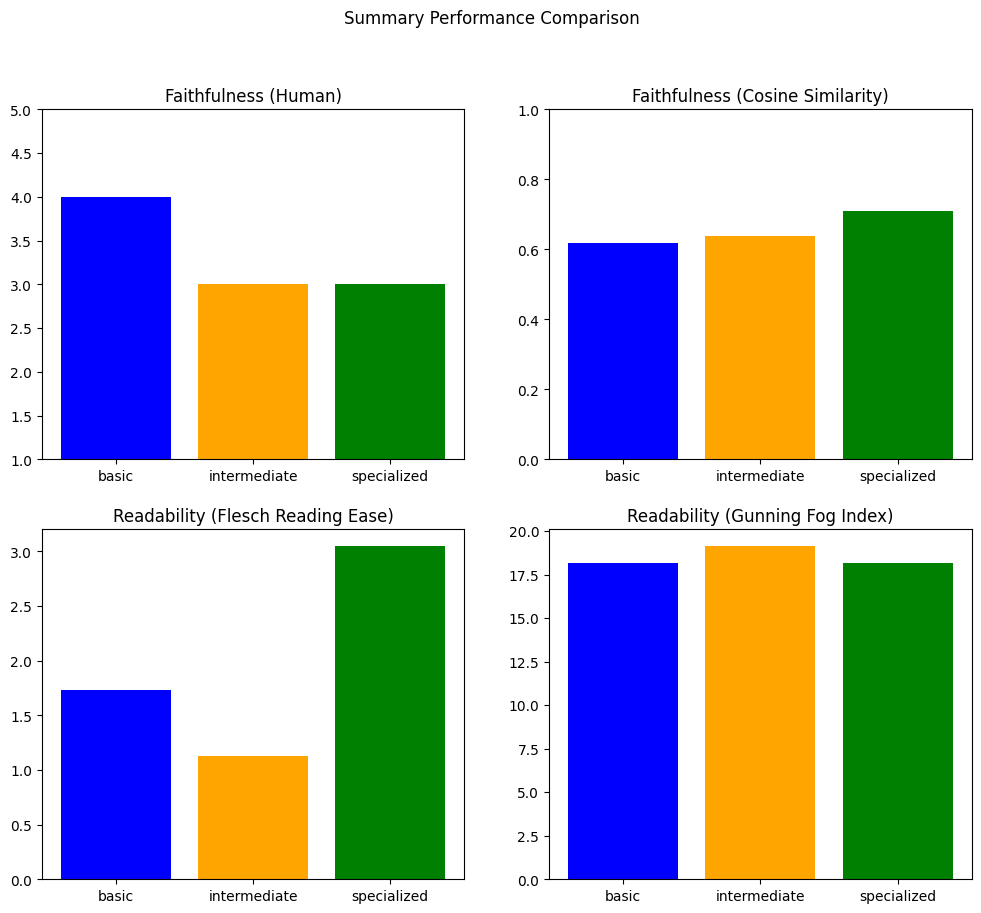

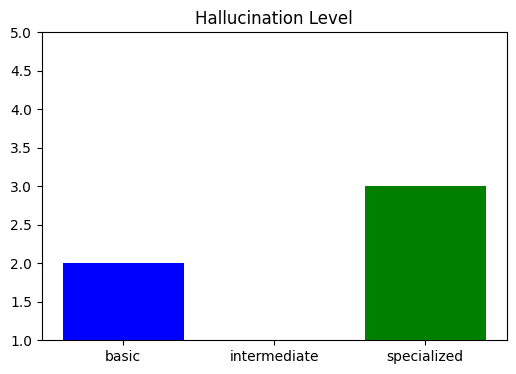

In [29]:
# plot performance
plot_performance(evaluation_results_all)

### LLM as a Judge

In [30]:
'''
def llm_judge(original_abstract, generated_summary, model, tokenizer, device='cpu'):
    """
    Uses another LLM agent to evaluate summary faithfulness and provide an explanation.
    """
    prompt = (
        f"Given the original abstract and the generated summary, compare the original abstract with the generated summary. "
        f"Are there things missing in the generated summary compared to the original abstract?\n\n"
        f"Original Abstract:\n{original_abstract}\n\n"
        f"Generated Summary:\n{generated_summary}\n\n"
        f"Your response should directly evaluate the summary compared to the original abstract:"
    )

    # tokenize input and send to model for generation
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # generate the output from the model
    output = model.generate(**inputs, max_new_tokens=300)

    # decode the output to get the explanation text
    explanation = tokenizer.decode(output[0], skip_special_tokens=True)

    return explanation
'''

'\ndef llm_judge(original_abstract, generated_summary, model, tokenizer, device=\'cpu\'):\n    """\n    Uses another LLM agent to evaluate summary faithfulness and provide an explanation.\n    """\n    prompt = (\n        f"Given the original abstract and the generated summary, compare the original abstract with the generated summary. "\n        f"Are there things missing in the generated summary compared to the original abstract?\n\n"\n        f"Original Abstract:\n{original_abstract}\n\n"\n        f"Generated Summary:\n{generated_summary}\n\n"\n        f"Your response should directly evaluate the summary compared to the original abstract:"\n    )\n\n    # tokenize input and send to model for generation\n    inputs = tokenizer(prompt, return_tensors="pt").to(device)\n\n    # generate the output from the model\n    output = model.generate(**inputs, max_new_tokens=300)\n\n    # decode the output to get the explanation text\n    explanation = tokenizer.decode(output[0], skip_special_toke

In [31]:
'''
def iterative_summary_refinement(article_id, df, retriever, qa_chain2, model, tokenizer, sim_model, max_iterations=3):
    """
    Iteratively refines the specialized summary based on LLM judge feedback.
    Goal is to improve faithfulness to the original abstract without seeing it.
    """
    article = df.iloc[article_id]
    title = article["title"]
    original_abstract = article["abstract"]

    retrieved_docs = retriever.get_relevant_documents(title)
    if not retrieved_docs:
        return {
            "title": title,
            "original_abstract": original_abstract,
            "retrieved_docs": [],
            "generated_summaries": {},
            "feedback_history": [],
        }

    queries = {
        "specialized": f"Provide a specialized summary of the research article titled: '{title}', focusing on key findings typically found in an abstract section."
    }

    feedback_history = []
    generated_summaries = {}

    # generate initial specialized summary
    query = queries["specialized"]
    print(f"\n Generating specialized summary...")

    response = qa_chain2.invoke(input={"query": query, "documents": retrieved_docs})
    specialized_summary = response.get('result', '').split('Answer:')[-1].strip()
    generated_summaries["specialized"] = specialized_summary

    print(f"\n **Generated Specialized Summary:**\n{specialized_summary}")

    # use LLM judge to evaluate the specialized summary
    feedback = llm_judge(original_abstract, specialized_summary, model, tokenizer, device='cuda')

    # store feedback
    feedback_history.append(("specialized", feedback))

    # iteratively refine the specialized summary based on feedback
    for iteration in range(max_iterations):
        print(f"\n **Iteration {iteration + 1}/{max_iterations}**")

        # use previous feedback to adjust the query
        feedback_text = feedback_history[-1][1]
        refinement_prompt = (
            f"Refine the summary by addressing the following feedback: {feedback_text}.\n"
            f"Ensure the summary is concise, accurate, and captures all key aspects of the research article titled '{title}'."
        )

        # generate refined specialized summary based on updated query
        response = qa_chain2.invoke(input={"query": refinement_prompt, "documents": retrieved_docs})
        refined_specialized_summary = response.get('result', '').split('Answer:')[-1].strip()
        generated_summaries["specialized"] = refined_specialized_summary

        print(f"\n **Refined Specialized Summary:**\n{refined_specialized_summary}")

        # use LLM judge to evaluate the refined summary
        feedback = llm_judge(original_abstract, refined_specialized_summary, model, tokenizer, device='cuda')

        # store feedback
        feedback_history.append(("specialized", feedback))

        print(f"\n **LLM Feedback for Refined Specialized Summary:** {feedback}\n")

    # print final summary and feedback
    print("\n **Final Specialized Summary and Feedback** ")
    final_specialized_summary = generated_summaries["specialized"]
    print(f"\n **Final Specialized Summary:**\n{final_specialized_summary}")
    final_feedback = feedback_history[-1][1]
    print(f" **Final LLM Feedback for Specialized Summary:** {final_feedback}\n")

    return {
        "title": title,
        "original_abstract": original_abstract,
        "retrieved_docs": [doc.page_content for doc in retrieved_docs],
        "generated_summaries": generated_summaries,
        "feedback_history": feedback_history,
    }
'''

'\ndef iterative_summary_refinement(article_id, df, retriever, qa_chain2, model, tokenizer, sim_model, max_iterations=3):\n    """\n    Iteratively refines the specialized summary based on LLM judge feedback.\n    Goal is to improve faithfulness to the original abstract without seeing it.\n    """\n    article = df.iloc[article_id]\n    title = article["title"]\n    original_abstract = article["abstract"]\n\n    retrieved_docs = retriever.get_relevant_documents(title)\n    if not retrieved_docs:\n        return {\n            "title": title,\n            "original_abstract": original_abstract,\n            "retrieved_docs": [],\n            "generated_summaries": {},\n            "feedback_history": [],\n        }\n\n    queries = {\n        "specialized": f"Provide a specialized summary of the research article titled: \'{title}\', focusing on key findings typically found in an abstract section."\n    }\n\n    feedback_history = []\n    generated_summaries = {}\n\n    # generate initia

In [32]:
'''
article_id = 6
final_results = iterative_summary_refinement(article_id, df, retriever, qa_chain2, llm_model, tokenizer, sim_model, max_iterations=3)
'''

'\narticle_id = 6  \nfinal_results = iterative_summary_refinement(article_id, df, retriever, qa_chain2, llm_model, tokenizer, sim_model, max_iterations=3)\n'

In [33]:
def llm_judge(original_abstract, generated_summary, model, tokenizer, device='cpu'):
    """
    Uses another LLM agent to evaluate summary faithfulness and provide actionable feedback.
    """
    prompt = (
        "You are an expert in summarization evaluation. Compare the original abstract with the generated summary and provide detailed feedback to improve the summary.\n"
        "1. **Missing Key Points:** List any critical information from the original abstract that the summary does not include.\n"
        "2. **Misinterpretations:** Identify any misrepresentations or deviations from the original abstract in the summary.\n"
        f"Original Abstract:\n{original_abstract}\n\n"
        f"Generated Summary:\n{generated_summary}\n\n"
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    output = model.generate(**inputs, max_new_tokens=310, num_return_sequences=1)
    explanation = tokenizer.decode(output[0], skip_special_tokens=True)

    return explanation


In [34]:
def generate_specialized_summary(query, retrieved_docs, qa_chain2):
    """
    Generate the specialized summary for the given article.
    """
    response = qa_chain2.invoke(input={"query": query, "documents": retrieved_docs})
    specialized_summary = response.get('result', '').split('Answer:')[-1].strip()
    return specialized_summary

In [35]:
def evaluate_summary_with_llm(original_abstract, specialized_summary, model, tokenizer):
    """
    Evaluate the generated summary using the LLM judge and return the feedback.
    """
    feedback = llm_judge(original_abstract, specialized_summary, model, tokenizer, device='cuda')
    return feedback

In [36]:
def refine_summary_based_on_feedback(feedback_text, prev_summary, retrieved_docs, qa_chain2, is_final_refinement=False):
    """
    Improve the summary based on feedback while ensuring clarity, completeness, and document faithfulness.
    Each iteration builds upon the last.
    """
    refinement_prompt = (
        f"Revise the following summary based on the feedback provided. "
        f"Make improvements by incorporating missing key details to enhance clarity and ensuring conciseness.\n\n"
        f"Previous Summary:\n{prev_summary}\n\n"
        f"Feedback:\n{feedback_text}\n\n"
        f"Provide an improved summary by integrating the necessary refinements."
    )

    response = qa_chain2.invoke(input={"query": refinement_prompt, "documents": retrieved_docs})
    refined_summary = response.get('result', '').split('Answer:')[-1].strip()
    return refined_summary

In [37]:
def iterative_summary_refinement(article_id, df, retriever, qa_chain2, model, tokenizer, sim_model, max_iterations=3):
    """
    Iteratively refines the specialized summary based on LLM judge feedback.
    The goal is to improve faithfulness to the retrieved documents, without revisiting the original abstract.
    """
    article = df.iloc[article_id]
    title = article["title"]
    original_abstract = article["abstract"]

    # retrieve relevant documents using retriever
    retrieved_docs = retriever.get_relevant_documents(title)
    if not retrieved_docs:
        return {
            "title": title,
            "original_abstract": original_abstract,
            "retrieved_docs": [],
            "generated_summaries": {},
            "feedback_history": [],
        }

    # specialized summary query
    query = f"Provide a specialized summary of the research article titled: '{title}', focusing on key findings typically found in an abstract section."

    feedback_history = []
    generated_summaries = {}

    # generate initial specialized summary
    specialized_summary = generate_specialized_summary(query, retrieved_docs, qa_chain2)
    generated_summaries["specialized"] = specialized_summary

    # use LLM judge to evaluate the initial summary
    feedback = evaluate_summary_with_llm(original_abstract, specialized_summary, model, tokenizer)
    feedback_history.append(("specialized", feedback))

    # refinement loop based on feedback
    for iteration in range(max_iterations):

        # use previous feedback to adjust the query for next iteration
        feedback_text = feedback_history[-1][1]  # feedback from last iteration
        is_final_refinement = (iteration == max_iterations - 1)  # mark as final iteration to avoid abstract influence
        refined_specialized_summary = refine_summary_based_on_feedback(feedback_text, title, retrieved_docs, qa_chain2, is_final_refinement)
        generated_summaries[f"refined_iteration_{iteration + 1}"] = refined_specialized_summary

        # use LLM judge to evaluate the refined summary
        feedback = evaluate_summary_with_llm(original_abstract, refined_specialized_summary, model, tokenizer)
        feedback_history.append((f"refined_{iteration + 1}", feedback))

    # final result after all iterations
    final_specialized_summary = generated_summaries[f"refined_iteration_{max_iterations}"]

    return {
        "title": title,
        "original_abstract": original_abstract,
        "retrieved_docs": [doc.page_content for doc in retrieved_docs],
        "generated_summaries": generated_summaries,
        "feedback_history": feedback_history,
        "final_specialized_summary": final_specialized_summary,
    }

In [38]:
article_id = 2
final_results = iterative_summary_refinement(article_id, df, retriever, qa_chain2, llm_model, tokenizer, sim_model, max_iterations=3)

# print generated summaries after refinement
print(f"\n**Generated Summaries after Refinement:**")
for iteration, summary in final_results["generated_summaries"].items():
    print(f"\n**{iteration.capitalize()} Summary:**\n{summary}")


**Generated Summaries after Refinement:**

**Specialized Summary:**
In the research article titled "EvoDynamic: A Framework for the Evolution of Generally Represented Dynamical Systems and Its Application to Criticality", authors discuss their work towards developing a framework called EvoDynamic which aims to evolve dynamically generated dynamical systems by means of genetic algorithms. They also describe how they have applied this framework to study the behavior of various systems such as the Conway's game of life with 7x7 cells and wrapped boundary conditions, and how it has led them to discover systems exhibiting criticality. Some key findings from the paper include identifying systems with criticality through genetic algorithm optimization, finding systems with criticality using a combination of genetic algorithm and other techniques, and studying the behavior of these systems using different methods including simulations and experimental data analysis. Overall, the research arti

In [39]:
# work with improvements across iterations

## Hallucination Detection and Mitigation

In [40]:
def sentence_cosine_similarity(sentences1, sentences2, model):
    """
    Calculate cosine similarity between sentences from two lists using the sentence transformer model.
    """
    embeddings1 = model.encode(sentences1, convert_to_tensor=True)
    embeddings2 = model.encode(sentences2, convert_to_tensor=True)
    similarities = cosine_similarity(embeddings1.cpu(), embeddings2.cpu())
    return similarities

In [58]:
def detect_hallucinations(article_id, df, retriever, qa_chain2, sim_model):
    """
    Identifies possible hallucinations in generated summaries based on low cosine similarity.
    """
    # get generated summaries and retrieved documents
    summary_data = abstract_summary_comparison(article_id, df, retriever, qa_chain2, sim_model)

    # extract relevant information
    article_text = df.iloc[article_id]["cleaned_content"]
    hallucinations = []

    # if no relevant documents were found, return empty list
    if not summary_data["retrieved_docs"]:
        return []

    for level, summary in summary_data["generated_summaries"].items():

        # split generated summary and article text into sentences
        summary_sentences = summary.split(". ")
        article_sentences = article_text.split(". ")

        # compute cosine similarity between each sentence in summary and each sentence in article text
        similarities = sentence_cosine_similarity(summary_sentences, article_sentences, sim_model)
        #print(similarities)
        plt.hist(similarities.flatten())
        break


        # identify hallucinations based on low similarity
        for idx, sim_score in enumerate(np.mean(similarities, axis=1)):
            if sim_score < 0.2:  # threshold can be adjusted
                hallucinations.append({
                    "summary_sentence": summary_sentences[idx],
                    "similarity_score": sim_score,
                    "article_sentence": article_sentences[np.argmax(similarities[idx])],
                    "level": level
                })

    return hallucinations

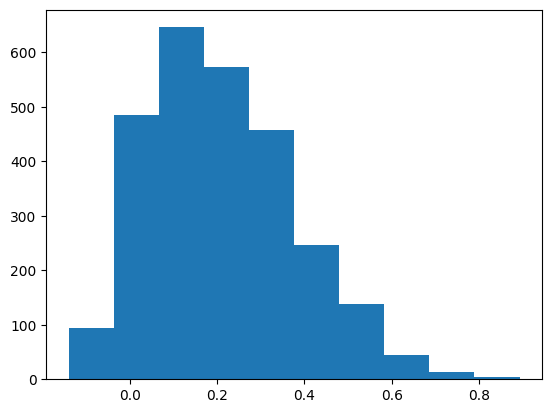

In [59]:
article_id = 1
hallucinations = detect_hallucinations(article_id, df, retriever, qa_chain2, sim_model)

for hallucination in hallucinations:
    print(f"Level: {hallucination['level']}")
    print(f"Summary Sentence: {hallucination['summary_sentence']}")
    print(f"Similarity Score: {hallucination['similarity_score']}")
    print(f"Most Similar Article Sentence: {hallucination['article_sentence']}")
    print("-" * 50)


# 25% quartile
# hallucination dataset on kaggle for case study
# summarization benchmark, check sources
# plot for every article with automated threshold, compare them
# plot shuffled abstracts
# max pooling techniques

## Shuffle Abstracts

In [43]:
def shuffle_abstracts(df):
    """
    Shuffles the abstracts and returns a list of shuffled abstracts, keeping the titles intact.
    """
    shuffled_abstracts = df["abstract"].tolist()
    random.shuffle(shuffled_abstracts)
    return shuffled_abstracts

In [44]:
def evaluate_shuffled_abstracts(article_id, df, retriever, qa_chain2, model, sim_model):
    """
    Compares the original abstract with its LLM-RAG generated summary, and then compares
    the same summary with a shuffled abstract. Calculates the cosine similarity before and after shuffling.
    """
    # extract original article details
    article = df.iloc[article_id]
    original_abstract = article["abstract"]
    title = article["title"]

    # retrieve relevant documents for summary generation
    retrieved_docs = retriever.get_relevant_documents(title)
    if not retrieved_docs:
        return {
            "title": title,
            "original_abstract": original_abstract,
            "retrieved_docs": [],
            "generated_summary": "No relevant documents found."
        }

    # generate summary using RAG
    query = f"Summarize the research article titled: {title}"
    response = qa_chain2.invoke(input={"query": query, "documents": retrieved_docs})
    generated_summary = response.get('result', '').split('Answer:')[-1].strip()

    # shuffle abstracts for comparison
    shuffled_abstracts = shuffle_abstracts(df)
    shuffled_abstract = shuffled_abstracts[article_id]

    # calculate cosine similarity for original abstract and generated summary
    original_embeddings = sim_model.encode([original_abstract, generated_summary])
    original_similarity = cosine_similarity([original_embeddings[0]], [original_embeddings[1]])[0][0]

    # calculate cosine similarity for shuffled abstract and generated summary
    shuffled_embeddings = sim_model.encode([shuffled_abstract, generated_summary])
    shuffled_similarity = cosine_similarity([shuffled_embeddings[0]], [shuffled_embeddings[1]])[0][0]

    # store results for comparison
    return {
        "title": title,
        "original_abstract": original_abstract,
        "shuffled_abstract": shuffled_abstract,
        "generated_summary": generated_summary,
        "Original Cosine Similarity": original_similarity,
        "Shuffled Cosine Similarity": shuffled_similarity
    }

In [45]:
article_ids = [3, 5, 8]
results = []

for article_id in article_ids:
    result = evaluate_shuffled_abstracts(article_id, df, retriever, qa_chain2, sim_model, sim_model)
    results.append(result)

# print results for verification
for result in results:
    print(f"Title: {result['title']}")
    print(f"Original Cosine Similarity: {result['Original Cosine Similarity']}")
    print(f"Shuffled Cosine Similarity: {result['Shuffled Cosine Similarity']}")
    print("="*50)

Title: A general representation of dynamical systems for reservoir computing
Original Cosine Similarity: 0.7255799770355225
Shuffled Cosine Similarity: 0.6213228106498718
Title: A Deep Learning-Based Tool for Automatic Brain Extraction from Functional Magnetic Resonance Images of Rodents
Original Cosine Similarity: 0.7055402994155884
Shuffled Cosine Similarity: 0.3222412168979645
Title: A New Adaptive Mixture Distance-Based Improved Density Peaks Clustering for Gearbox Fault Diagnosis
Original Cosine Similarity: 0.7390023469924927
Shuffled Cosine Similarity: 0.03772927075624466


In [46]:
# combine evaluations, ex faithfullness of human and faithfullness from cosine similarity
# put the results in a table
# trick questions
# ROUGE
# hybrid / dense retrieval
# heatmap correlation

## Vizualisation

In [47]:
# load embeddings from Chroma
embeddings = vectorstore._collection.get(include=['embeddings'])['embeddings']
document_embeddings = np.array(embeddings)

# reduce dimensions with PCA to speed up TSNE and UMAP
pca = PCA(n_components=50)
pca_embeddings = pca.fit_transform(document_embeddings)

In [48]:
# apply T-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_embeddings = tsne.fit_transform(pca_embeddings)

# apply UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_reducer.fit_transform(pca_embeddings)

# apply KMeans clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels_tsne = kmeans.fit_predict(tsne_embeddings)
cluster_labels_umap = kmeans.fit_predict(umap_embeddings)

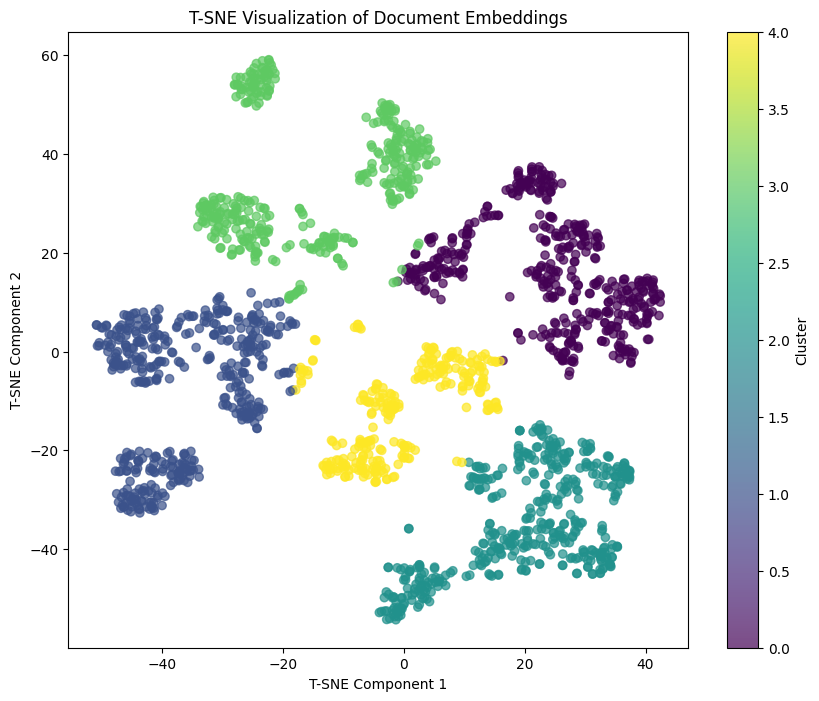

In [49]:
# plot T-SNE
plt.figure(figsize=(10, 8))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_labels_tsne, cmap='viridis', alpha=0.7)
plt.colorbar(label="Cluster")
plt.title("T-SNE Visualization of Document Embeddings")
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
plt.show()

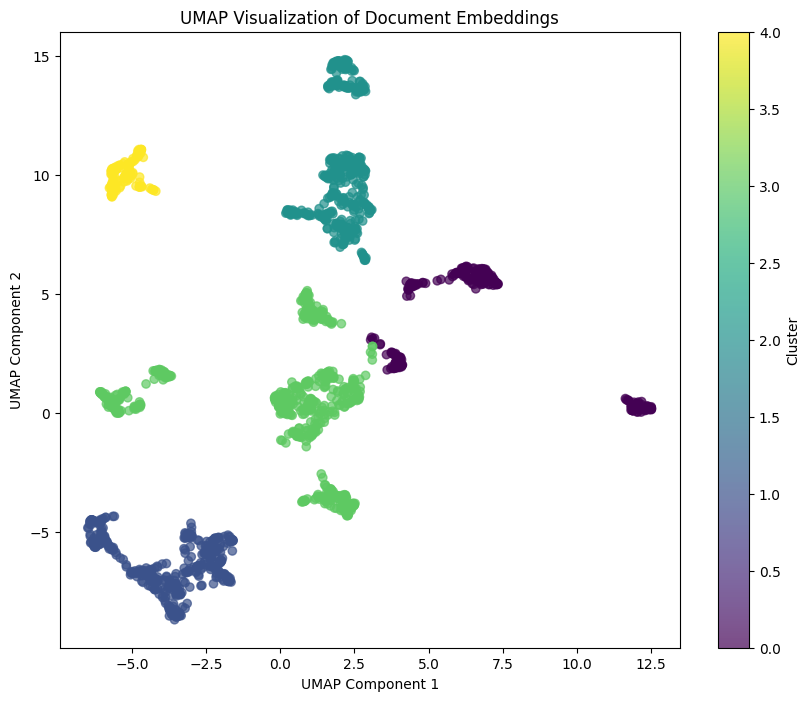

In [50]:
# plot UMAP
plt.figure(figsize=(10, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=cluster_labels_umap, cmap='viridis', alpha=0.7)
plt.colorbar(label="Cluster")
plt.title("UMAP Visualization of Document Embeddings")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

In [51]:
# load document texts
documents = vectorstore._collection.get(include=['documents'])['documents']

# convert text to document-term matrix
vectorizer = CountVectorizer(stop_words='english', max_df=0.9, min_df=5)
dtm = vectorizer.fit_transform(documents)

# train LDA model
num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

# print top words for each topic
words = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_words = [words[i] for i in topic.argsort()[-10:]]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")


Topic 1: used, sperm, deep, ded, ai, model, learning, images, al, et
Topic 2: use, different, learning, language, models, model, rule, ai, journalism, data
Topic 3: random, space, algorithm, function, value, number, state, fig, matrix, ca
Topic 4: algorithm, results, variant, using, learning, based, os, time, la, tcp
Topic 5: 20, university, networks, doi, 12, network, 10, ieee, pp, vol


In [52]:
# extract text documents
documents = vectorstore._collection.get(include=['documents'])['documents']

# initialize BERTopic
topic_model = BERTopic()

# fit the model
topics, probs = topic_model.fit_transform(documents)

# get the top topics
topic_model.get_topic_info()

# vizualise chart
topic_model.visualize_barchart(top_n_topics=5)